# Solving the n-Queens Problem using Local Search

## Instructions

Total Points: Undergrads 100 / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a PDF file. 


## The n-Queens Problem

* __Goal:__ Find an arrangement of $n$ queens on a $n \times n$ chess board so that no queen is on the same row, column or diagonal as any other queen.

* __State space:__ An arrangement of the queens on the board. We restrict the state space to arrangements where there is only a single queen per column. We represent a state as an integer vector $\mathbf{q} = \{q_1, q_2, \dots, q_n\}$, each number representing the row positions of the queens from left to right. We will call a state a "board."

* __Objective function:__ The number of pairwise conflicts (i.e., two queens in the same row/column/diagonal).
The optimization problem is to find the optimal arrangement $\mathbf{q}^*$ of $n$ queens on the board can be written as:

  > minimize: $\mathrm{conflicts}(\mathbf{q})$
  >
  > subject to: $\mathbf{q} \ \text{contains only one queen per column}$

  Note: the constraint (subject to) is enforced by the definition of the state space.

* __Local improvement move:__ Move one queen to a different row in its column.

* __Termination:__ For this problem there is always an arrangement $\mathbf{q}^*$ with $\mathrm{conflicts}(\mathbf{q}^*) = 0$, however, the local improvement moves might end up in a local minimum. 

## Helper functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

import warnings
warnings.filterwarnings("ignore")

np.random.seed(1234)

def random_board(n):
    """Creates a random board of size n x n. Note that only a single queen is placed in each column!"""
    
    return(np.random.randint(0,n, size = n))

def comb2(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

def conflicts(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
    
    horizontal_cnt = [0] * n
    diagonal1_cnt = [0] * 2 * n
    diagonal2_cnt = [0] * 2 * n
    
    for i in range(n):
        horizontal_cnt[board[i]] += 1
        diagonal1_cnt[i + board[i]] += 1
        diagonal2_cnt[i - board[i] + n] += 1
    
    return sum(map(comb2, horizontal_cnt + diagonal1_cnt + diagonal2_cnt))


def show_board(board, cols = ['white', 'gray'], fontsize = 48):  
    """display the board"""
    
    n = len(board)
    
    # create chess board display
    display = np.zeros([n,n])
    for i in range(n):
        for j in range(n):
            if (((i+j) % 2) != 0): 
                display[i,j] = 1
    
    cmap = colors.ListedColormap(cols)
    fig, ax = plt.subplots()
    ax.imshow(display, cmap = cmap, 
              norm = colors.BoundaryNorm(range(len(cols)+1), cmap.N))
    ax.set_xticks([])
    ax.set_yticks([])
    
    # place queens. Note: Unicode u265B is a black queen
    for j in range(n):
        plt.text(j, board[j], u"\u265B", fontsize = fontsize, 
                 horizontalalignment = 'center',
                 verticalalignment = 'center')
    
    print(f"Board with {conflicts_jit(board)} conflicts.")
    plt.show()

## Create a board

Board with 4 conflicts.


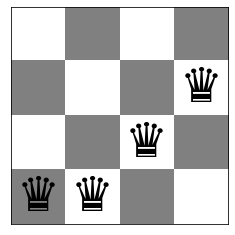

Queens (left to right) are at rows: [3 3 2 1]
Number of conflicts: 4


In [4]:
board = random_board(4)

show_board(board)
print(f"Queens (left to right) are at rows: {board}")
print(f"Number of conflicts: {conflicts(board)}")

A board $4 \times 4$ with no conflicts:

Board with 0 conflicts.


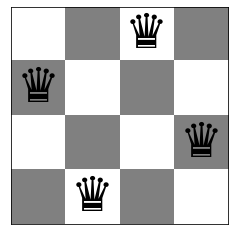

In [5]:
board = [1,3,0,2]
show_board(board)

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook. Sync your forked repository and pull the latest revision. 
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formated professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Steepest-ascend Hill Climbing Search [30 Points]

Calculate the objective function for all local moves (see definition of local moves above) and always choose the best among all local moves. If there are no local moves that improve the objective, then you have reached a local optimum. 

In [6]:
from numba import njit
#objective function taken from Dr. Hahsler 
# with jit (cannot use some Python functions like sum)
@njit()
def comb2_jit(n): return n*(n-1)//2 # this is n choose 2 equivalent to math.comb(n, 2); // is int division

@njit()
def conflicts_jit(board):
    """Caclulate the number of conflicts, i.e., the objective function."""

    n = len(board)
 
    cnt = [0] * (5 * n)
 
    for i in range(n):
        cnt[board[i]] += 1
        cnt[(n) + (i + board[i])] += 1
        cnt[(3 * n) + (i - board[i] + n)] += 1
 
    conflicts = 0
    for x in cnt:
        conflicts += comb2_jit(x)
 
    return conflicts

Board with 4 conflicts.


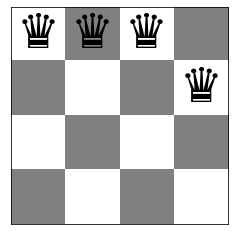

Board with 0 conflicts.


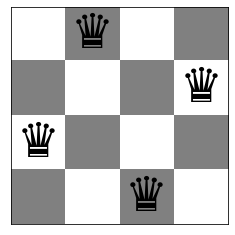

Queens (left to right) are at rows: [2 0 3 1]
Number of conflicts: 0


In [7]:
# Code and description go here
#This code goes through all moves to try and find the best local optimum
def steepest_ascend_hill_climbing(board):
    #get the size of the board
    n = len(board)
    #store how many conflifts athere are initialy
    initial = conflicts_jit(board)
    #store the inital board state
    local_optimum = board.copy()
    while True:
        #store the current state
        new_state = board.copy()
        q = 0
        #iterate for every queen
        for q in range(n):
            i = 0
            #iterate over every position
            for i in range(n):
                #get the current state
                current_state = new_state.copy()
                #move the queen
                current_state[i] = q
                #see how many conflicts there are
                local_move = conflicts_jit(current_state)
                #if there are less conflicts then there are previously state
                if(local_move < initial):
                    #the current move is the new state
                    new_state = current_state
                    #store the new total of conflicts
                    initial = local_move
                    #the current state is the new local optimum
                    local_optimum = current_state     
        break
    #return the finial state
    return local_optimum

board = random_board(4)
show_board(board)
new_board = steepest_ascend_hill_climbing(board)

show_board(new_board)
print(f"Queens (left to right) are at rows: {new_board}")
print(f"Number of conflicts: {conflicts_jit(new_board)}")


## Task 2: Stochastic Hill Climbing 1 [10 Points]

Chooses randomly from among all uphill moves till you have reached a local optimum.

Board with 7 conflicts.


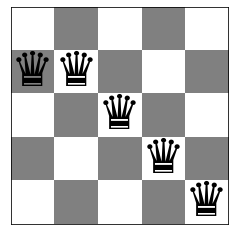

Board with 4 conflicts.


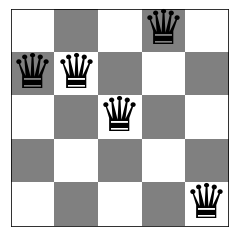

Queens (left to right) are at rows: [1 1 2 0 4]
Number of conflicts: 4


In [8]:
# Code and description go here
import random
#This code goes through all moves then random selects moves to try and find local optimum
def stochastic_hill_climbing1(board):
    #storre the size of the board
    n = len(board)
    #store the current number of conflicts from the board
    initial = conflicts_jit(board)
    #store the current state best local optimum
    local_optimum = board.copy()
    #list of all uphill moves
    uphill_moves = []
    #if there is a better move that reduces the number of conflicts set at true
    found = False
    #store inital board state
    new_state = board.copy()
    q = 0
    #store the size of how many moves there are
    size = 0
    #counter if stuck at plateu
    count = 0
    #interate through all queens
    for q in range(n):
        i = 0
        #iterate through all positions
        for i in range(n):
            #copy the current state
            current_state = new_state.copy()
            #move the queen
            current_state[i] = q
            #add it to the list
            uphill_moves.append(current_state)
            #increate the size
            size += 1
    #contuine loop
    while True:
        #print(size)
        #randomly pick a number
        random_move = random.randint(0,size - 1)
        #print(random_move)
        #radomly choose a board
        random_board = uphill_moves[random_move]
        #soo how many conflicts there are
        local_move = conflicts_jit(random_board)
        #if there are small number of conflicts 
        if(local_move < initial):
            #store the board
            new_state = random_board
            #store the number of conflicts
            initial = local_move
            #store the local optimum
            local_optimum = random_board
            #set found at true
            found = True
        #if there is a local optimum break the loop 
        #or if we are on a pleatu and there are no better moves
        if(found == True or count == n * 100):
            break
        #if there are no conflicts return
        if(initial == 0):
            break
        count += 1
    #return the board 
    return local_optimum

board = random_board(5)
show_board(board)
new_board = stochastic_hill_climbing1(board)

show_board(new_board)
print(f"Queens (left to right) are at rows: {new_board}")
print(f"Number of conflicts: {conflicts_jit(new_board)}")


## Task 3: Stochastic Hill Climbing 2 [20 Points]

A popular version of stochastic hill climbing generates only a single random local neighbor at a time and accept it if it has a better objective function value than the current state. This is very efficient if each state has many possible successor states. This method is called "First-choice hill climbing" in the textbook.

__Notes:__ 

* Detecting local optima is tricky! You can, for example, stop if you were not able to improve the objective function during the last $x$ tries.

Board with 4 conflicts.


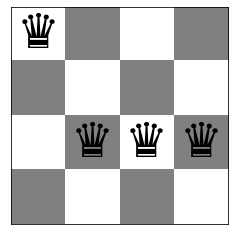

Board with 0 conflicts.


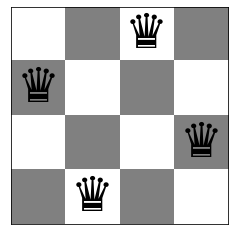

Queens (left to right) are at rows: [1 3 0 2]
Number of conflicts: 0


In [9]:
# Code and description go here
#this function randomly picks queens and randomly moves them to find the local optimum
def stochastic_hill_climbing2(board):
    #store the board length
    n = len(board)
    #store the inital number of conflicts
    initial = conflicts_jit(board)
    #store the best board
    local_optimum = board.copy()
    #store a new state
    new_state = board.copy()
    #count integer
    count = 0
    #while count hasn't reach an arbitratry value
    while count < n * 1000:
        #randomly pick a queen
        queen = random.randint(0, n - 1)
        #randomly move it
        move = random.randint(0, n - 1)
        #store the current state
        random_board = new_state.copy()
        #move queen to the radomly pick position
        random_board[queen] = move
        #see how many conflicts that created
        local_move = conflicts_jit(random_board)
        #increate the count by one
        count += 1
        #if the local move is better that the previous state
        if(local_move < initial):
            #store the new state
            new_state = random_board
            #store the new minumum 
            initial = local_move
            #store the new local optimum board
            local_optimum = random_board
        #if there are zero conflicts exist the loop
        if(initial == 0):
            break
    #return the board
    return local_optimum

board = random_board(4)
show_board(board)
new_board = stochastic_hill_climbing2(board)

show_board(new_board)
print(f"Queens (left to right) are at rows: {new_board}")
print(f"Number of conflicts: {conflicts_jit(new_board)}")



## Task 4: Hill Climbing Search with Random Restarts [10 Points]

Hill climbing will often end up in local optima. Restart the each of the three hill climbing algorithm up to 100 times with a random board to find a better (hopefully optimal) solution. Note that restart just means to run the algoithm several times starting with a new random board.

Size of board:  19
Initial board
Board with 17 conflicts.


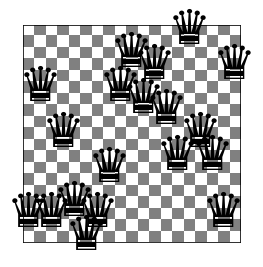

run: 100/100

Steepest Ascend Hill Climbing found a local optima at run:  4
Board with 1 conflicts.


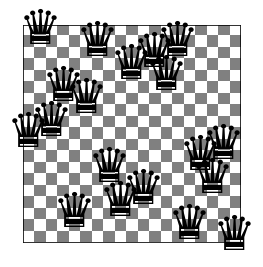

Stochastic Hill Climbing1 found a local optima at run:  37
Board with 11 conflicts.


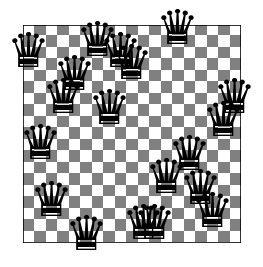

Stochastic Hill Climbing2 found a local optima at run:  15
Board with 0 conflicts.


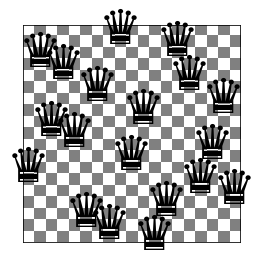

In [10]:
# Code and description go here
#this code goes for 100 runs and ranomly generates a board from size 4 thorugh 20 
#It then runs all 3 hill cimbing algorithums to see how long it takes to find the local optimum
import random 
import sys

board_size = random.randint(4, 20)
SAHC_lo = 0
SHC1_lo = 0
SHC2_lo = 0
board = random_board(board_size)
SAHC_board = board.copy()
SHC1_board = board.copy()
SHC2_board = board.copy()
print("Size of board: ", board_size)
print("Initial board")
show_board(board)
initial_SAHC = conflicts_jit(board)
initial_SHC1 = conflicts_jit(board)
initial_SHC2 = conflicts_jit(board)
for i in range(100):
    
    if i>0:
        sys.stderr.write('\rrun: %d/%d' % (i+1, 100))
        sys.stderr.flush()
                
    board = random_board(board_size)
    
    SAHC = steepest_ascend_hill_climbing(board)
    SAHC_conflicts = conflicts_jit(SAHC)
    if(SAHC_conflicts < initial_SAHC):
        initial_SAHC = SAHC_conflicts
        SAHC_lo = i
        SAHC_board = SAHC
        
    SHC1 = stochastic_hill_climbing1(board)
    SHC1_conflicts = conflicts_jit(SHC1)
    if(SHC1_conflicts < initial_SHC1):
        initial_SHC1 = SHC1_conflicts
        SHC1_lo = i
        SHC1_board = SHC1
        
    SHC2 = stochastic_hill_climbing2(board)
    SHC2_conflicts = conflicts_jit(SHC2)
    if(SHC2_conflicts < initial_SHC2):
        initial_SHC2 = SHC2_conflicts
        SHC2_lo = i
        SHC2_board = SHC2

print("Steepest Ascend Hill Climbing found a local optima at run: ", SAHC_lo)
show_board(SAHC_board)

print("Stochastic Hill Climbing1 found a local optima at run: ", SHC1_lo)
show_board(SHC1_board)

print("Stochastic Hill Climbing2 found a local optima at run: ", SHC2_lo)
show_board(SHC2_board)

## Task 5: Compare Performance [20 Points]

Use runtime and objective function value to compare the algorithms. 

* Use boards of different sizes to explore how the different algorithms perform. Make sure that you run the algorithms for each board size several times (at least 10 times) with different starting boards and report averages.

* How do the algorithms scale with problem size? Use tables and charts.

* What is the largest board each algorithm can solve in a reasonable amount time?

See [Profiling Python Code](../Python_Code_Examples/profiling_code.ipynb) for help about how to measure runtime in Python.

Board Size: 50/50

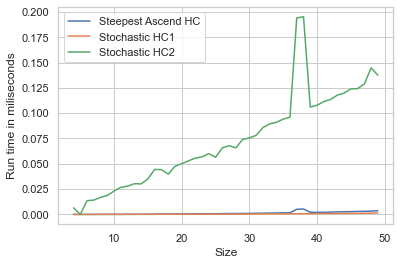

In [22]:
# Code, results, charts and discussion go here
import time
board_size = 4

SAHC_Time = []
SHC1_Time = []
SHC2_Time = []

SAHC_Conflicts = []
SHC1_Conflicts = []
SHC2_Conflicts = []

#start board size at 4 
board_size = 4
#go through 25 board sizes
for i in range(4, 50):
    
    if i>0:
        sys.stderr.write('\rBoard Size: %d/%d' % (i+1, 50))
        sys.stderr.flush()
        
    Time = 0
    conflicts = 0
    for j in range(10):
        board = random_board(board_size)
        t0 = time.time()
        SAHC = steepest_ascend_hill_climbing(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        conflicts = conflicts_jit(SAHC)
        SAHC_conflicts = SAHC_conflicts + conflicts
    
    Time = Time / 10
    SAHC_conflicts = SAHC_conflicts / 10
    SAHC_Time.append(Time)
    SAHC_Conflicts.append(SAHC_conflicts)
    
    Time = 0
    conflicts = 0
    for j in range(10):
        board = random_board(board_size)
        t0 = time.time()
        SHC1 = stochastic_hill_climbing1(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        conflicts = conflicts_jit(SHC1)
        SHC1_conflicts = SHC1_conflicts + conflicts
        
        
    Time = Time / 10
    SHC1_conflicts = SHC1_conflicts / 10
    SHC1_Time.append(Time)
    SHC1_Conflicts.append(SHC1_conflicts)
    
    Time = 0
    conflicts = 0
    for j in range(10):
        board = random_board(board_size)
        t0 = time.time()
        SHC2 = stochastic_hill_climbing2(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        conflicts = conflicts_jit(SHC2)
        SHC2_conflicts = SHC2_conflicts + conflicts
        
        
    Time = Time / 10
    SHC2_conflicts = SHC2_conflicts / 10
    SHC2_Time.append(Time)
    SHC2_Conflicts.append(SHC2_conflicts)
    
    board_size += 1
    

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
x=range(4,50)

plt.plot(x, SAHC_Time, label = "Steepest Ascend HC")
plt.plot(x, SHC1_Time, label = "Stochastic HC1")
plt.plot(x, SHC2_Time, label = "Stochastic HC2")
plt.xlabel("Size")
plt.ylabel("Run time in miliseconds")
plt.legend()
plt.show()



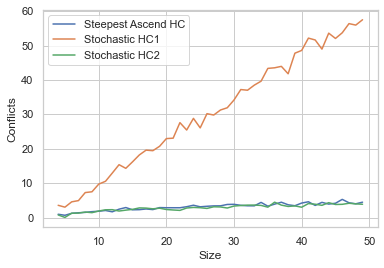

In [23]:
sns.set(style="whitegrid")
x=range(4,50)

plt.plot(x, SAHC_Conflicts, label = "Steepest Ascend HC")
plt.plot(x, SHC1_Conflicts, label = "Stochastic HC1")
plt.plot(x, SHC2_Conflicts, label = "Stochastic HC2")
plt.xlabel("Size")
plt.ylabel("Conflicts")
plt.legend()
plt.show()

My code above ran timing and conflicts for board sizes 4- 25 to see the overall performance. 
Steepest Ascend and Stochastic HC2 both preformed the same in the number of conflicts that are found from the local optima, however SHC2 did take longer to run. The reason why it took longer to run is becaause it's randomly moving and randomly picking queens which means there is a high chance for a radom move to not imporve the number of conflicts. Also this could be because my function contuines to a random count. Steepest Ascend is the best algorithum performance whise however it is only doing local moves os it does not find a solution. SHC1 is the worst algorithm since the number of conflicts increase as the board size increases it's time performance is quick. 

Board Size: 10/10

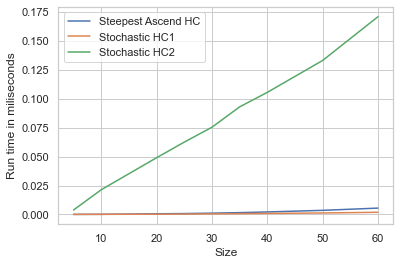

In [24]:
import time
board_size = 4

SAHC_Time = []
SHC1_Time = []
SHC2_Time = []

#start board size at 4 
board_size = 4
#go through 25 board sizes
board_sizes = [5,10,15,20,25,30,35,40,50,60]
counter = 0
for i in board_sizes:
    if i>0:
        sys.stderr.write('\rBoard Size: %d/%d' % (counter+1, 10))
        sys.stderr.flush()
        
    Time = 0
    for j in range(10):
        board = random_board(board_sizes[counter])
        t0 = time.time()
        SAHC = steepest_ascend_hill_climbing(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
    
    Time = Time / 10
    SAHC_Time.append(Time)
    
    Time = 0
    for j in range(10):
        board = random_board(board_sizes[counter])
        t0 = time.time()
        SHC1 = stochastic_hill_climbing1(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        
    Time = Time / 10
    SHC1_Time.append(Time)
    
    Time = 0
    for j in range(10):
        board = random_board(board_sizes[counter])
        t0 = time.time()
        SHC2 = stochastic_hill_climbing2(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        
        
    Time = Time / 10
    SHC2_Time.append(Time)
    
    counter += 1

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
x=board_sizes

plt.plot(x, SAHC_Time, label = "Steepest Ascend HC")
plt.plot(x, SHC1_Time, label = "Stochastic HC1")
plt.plot(x, SHC2_Time, label = "Stochastic HC2")
plt.xlabel("Size")
plt.ylabel("Run time in miliseconds")
plt.legend()
plt.show()

I ran each algorithum on 10 sizes so see if they coulkd find a solution all were successful in finding a solution up to a size off 60. However SHC2 would take a long time because the time is starting to increase exponetialy. Also Steepest Ascend is starting to seperate form SHC1. Each board was repeated 10 time to take an average, the timing would be increase if it was any longer.

## Graduate student advanced task: Simulated Annealing [10 Points]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+5 Bonus Points].

Simulated annealing is a form of stochastic hill climbing that avoid local optima by also allowing downhill moves with a probability proportional to a temperature. The temperature is decreased in every iteration following an annealing schedule. You have to experiment with the annealing schedule (Google to find guidance on this).


1. Implement simulated annealing for the n-Queens problem.
2. Compare the performance with the previous algorithms. 
2. Discuss your choice of annealing schedule.

Board with 6 conflicts.


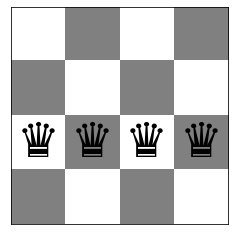

Board with 3 conflicts.


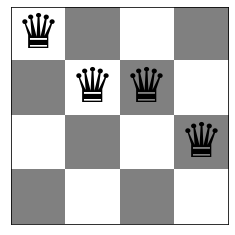

Queens (left to right) are at rows: [0 1 1 2]
Number of conflicts: 3


In [12]:
# Code and description go here
import math
import random

def Simulated_Annealing(board):
    #inital temperature
    T = 1.0
    #min Temp
    Tmin = 0.0001
    #temperature cooling rate
    decay_rate = 0.9
    #get the size of the board
    n = len(board)
    #store how many conflifts athere are initialy
    initial = conflicts_jit(board)
    #store the best board
    local_optimum = board.copy()
    #store a new state
    new_state = board.copy()
    while T > Tmin:
        #take 100 steps per decay
        i = 0
        for i in range(100):
            #randomly pick a queen
            queen = random.randint(0, n - 1)
            #randomly move it
            move = random.randint(0, n - 1)
            #store the current state
            random_board = new_state.copy()
            #move queen to the radomly pick position
            random_board[queen] = move
            #see how many conflicts that created
            local_move = conflicts_jit(random_board)
            #defind delta
            ap =  math.exp(-0.1 / T)
            #see if the delta is higher than the random number
            if ap > random.uniform(0, 1):
                #store the output if it is
                inital = local_move
                local_optimum = random_board.copy()
                new_state = random_board.copy()
        T = T * decay_rate
        
    return local_optimum

board = random_board(4)
show_board(board)
new_board = Simulated_Annealing(board)

show_board(new_board)
print(f"Queens (left to right) are at rows: {new_board}")
print(f"Number of conflicts: {conflicts_jit(new_board)}")
    

Board Size: 50/50

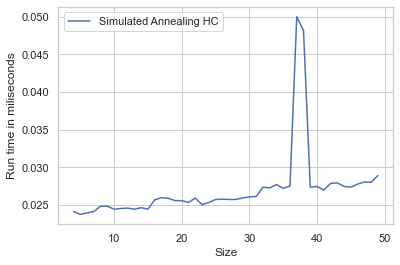

In [25]:
import time
board_size = 4

SA_Time = []

SA_Conflicts = []

#start board size at 4 
board_size = 4
#go through 25 board sizes
for i in range(4, 50):
    
    if i>0:
        sys.stderr.write('\rBoard Size: %d/%d' % (i+1, 50))
        sys.stderr.flush()
        
    Time = 0
    conflicts = 0
    SA_conflicts = 0
    for j in range(10):
        board = random_board(board_size)
        t0 = time.time()
        SA = Simulated_Annealing(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        conflicts = conflicts_jit(SA)
        SA_conflicts = SA_conflicts + conflicts
    
    Time = Time / 10
    SA_conflicts = SA_conflicts / 10
    SA_Time.append(Time)
    SA_Conflicts.append(SA_conflicts)
    
    
    board_size += 1
    

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
x=range(4,50)

plt.plot(x, SA_Time, label = "Simulated Annealing HC")
plt.xlabel("Size")
plt.ylabel("Run time in miliseconds")
plt.legend()
plt.show()

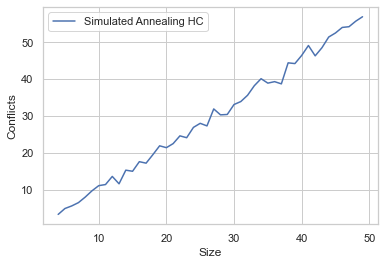

In [21]:
sns.set(style="whitegrid")
x=range(4,50)

plt.plot(x, SA_Conflicts, label = "Simulated Annealing HC")
plt.xlabel("Size")
plt.ylabel("Conflicts")
plt.legend()
plt.show()

The Simulated Annealing alogrithum has a relativly low run time there is a few board sizes where the algo suddenly took a while that is beacuse the CPU interupted the time or the math calulations suddenly took a bit too long. however I do not believe that would any cause for concern. The algorithims is a a combination of SHC1 and SCH2, however the timing could be lowered with a different decay rate. My SA randomly picks states and that is the reason my the number of conflicts go up. 

## More things to do

Implement a Genetic Algorithm for the n-Queens problem.

Board with 4 conflicts.


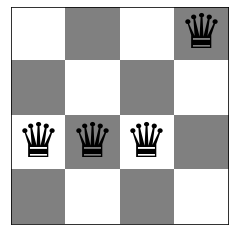

Board with 6 conflicts.


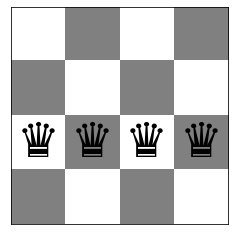

Queens (left to right) are at rows: [2 2 2 2]
Number of conflicts: 6


In [13]:
# Code and description go here
def Genetic_algo(board):
    #get the size of the board
    n = len(board)
    #store how many conflifts athere are initialy
    initial = conflicts_jit(board)
    #store the best board
    local_optimum = board.copy()
    #store a new state
    new_state = board.copy()
    #set inital population size
    pop_size = 10
    population = []
    for child in range(pop_size):
        #randomly pick a queen
        queen = random.randint(0, n - 1)
        #randomly move it
        move = random.randint(0, n - 1)
        #store the current state
        random_board = new_state.copy()
        #move queen to the radomly pick position
        random_board[queen] = move
        population.append(random_board)
    #iterate over the population
    count = 0
    while count < n * 1000:
        #define a new population
        new_population = []
        #generate new pop from old pop
        for i in range(pop_size):
            x = random.randint(0, len(population) - 1)
            local_move = population[x]
            copy = local_move.copy()
            #randomly pick a queen
            queen = random.randint(0, n - 1)
            #randomly move it
            move = random.randint(0, n - 1)
            copy[queen] = move
            if(random.uniform(0, 1) < 0.5):
                new_population.append(copy)
            else:
                new_population.append(local_move)
            population = new_population
        count += 1
    
    for child in range(pop_size):
        local_move = conflicts_jit(population[child])
        if(local_move < initial):
            #store the new minumum 
            initial = local_move
            #store the new local optimum board
            local_optimum = random_board
    return local_optimum


board = random_board(4)
show_board(board)
new_board = Genetic_algo(board)

show_board(new_board)
print(f"Queens (left to right) are at rows: {new_board}")
print(f"Number of conflicts: {conflicts_jit(new_board)}")
        

Board Size: 25/25

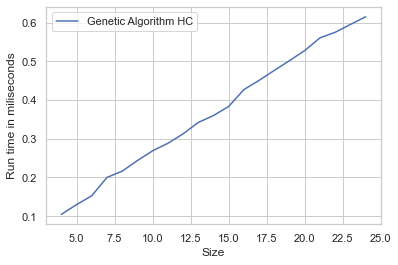

In [18]:
import time
board_size = 4

GA_Time = []

GA_Conflicts = []

#start board size at 4 
board_size = 4
#go through 25 board sizes
for i in range(4, 25):
    
    if i>0:
        sys.stderr.write('\rBoard Size: %d/%d' % (i+1, 25))
        sys.stderr.flush()
        
    Time = 0
    conflicts = 0
    GA_conflicts = 0
    for j in range(10):
        board = random_board(board_size)
        t0 = time.time()
        GA = Genetic_algo(board)
        t1 = time.time()
        Time = (t1 - t0) + Time
        conflicts = conflicts_jit(GA)
        GA_conflicts = GA_conflicts + conflicts
    
    Time = Time / 10
    GA_conflicts = GA_conflicts / 10
    GA_Time.append(Time)
    GA_Conflicts.append(GA_conflicts)
    
    
    board_size += 1
    

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
x=range(4,25)

plt.plot(x, GA_Time, label = "Genetic Algorithm HC")
plt.xlabel("Size")
plt.ylabel("Run time in miliseconds")
plt.legend()
plt.show()

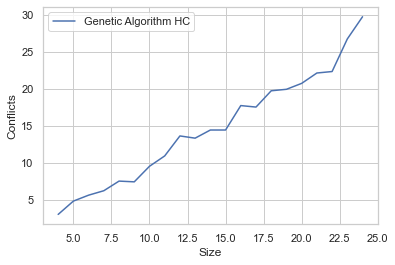

In [19]:
sns.set(style="whitegrid")
x=range(4,25)

plt.plot(x, GA_Conflicts, label = "Genetic Algorithm HC")
plt.xlabel("Size")
plt.ylabel("Conflicts")
plt.legend()
plt.show()

Gentic algorithum is the worst permormer of all the algoithums, now this is because the algoithums has to contuine to a large
step size. The algorithum works in that it radomly mutates a parent and then radmoly adds it to the new population. this 
does allow lower amount of conflicts then SHC2 and SA, however the runtime does take a bit longer.  